In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# inception.py:41: UserWarning: Scripted Inception3 always returns Inception3 Tuple

In [2]:
# mean and sd for images size 299,299
mean = [0.1854, 0.1854, 0.1855]
std = [0.2005, 0.2005, 0.2005]

batch_size = 32
model_path = '../models/inception_v3_5.pt'

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
test_dataset = datasets.ImageFolder(root="../data/Testing", transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = torch.jit.load(model_path)
model.to(device)
model.eval()
print(end="")

In [3]:
def generate_saliency_map(model, image, label):
    # Enable gradient tracking for the input image
    image.requires_grad_()  

    output, _ = model(image)

    # TODO: new images so no labels
    # _, predicted_label = torch.max(outputs, 1)
    output_class = output[0, label]

    # Backward pass to compute gradients
    model.zero_grad()
    output_class.backward()

    # Get the absolute value of the gradients (saliency map)
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)

    return saliency

def create_circular_mask(h, w, center=None, radius=None):
    """Generate a circular mask to highlight the brain area."""
    if center is None:
        center = (int(w / 2), int(h / 2))
    if radius is None:
        radius = min(center[0], center[1], w - center[0], h - center[1]) - 30

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask

In [4]:
# Select a single image from the batch
image, label = [], []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    image = images[0].unsqueeze(0)  # Add batch dimension (model expects image, batch)
    label = labels[0] 

    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


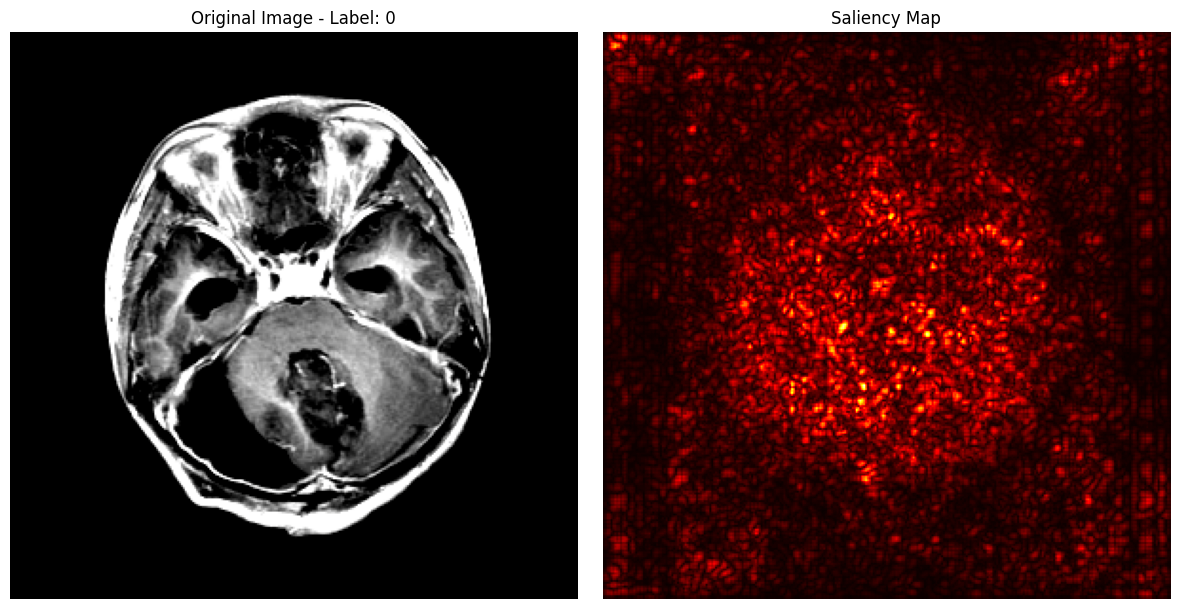

In [5]:
# Create a saliency map
saliency_map = generate_saliency_map(model, image, label)
saliency_map = saliency_map.squeeze().cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display Original image
ax[0].imshow(image.squeeze().permute(1, 2, 0).detach().cpu().numpy())
ax[0].set_title(f"Original Image - Label: {label.item()}")
ax[0].axis("off")

# Display Saliency map
ax[1].imshow(saliency_map, cmap='hot')
ax[1].set_title(f"Saliency Map")
ax[1].axis("off")

plt.tight_layout()
plt.show()

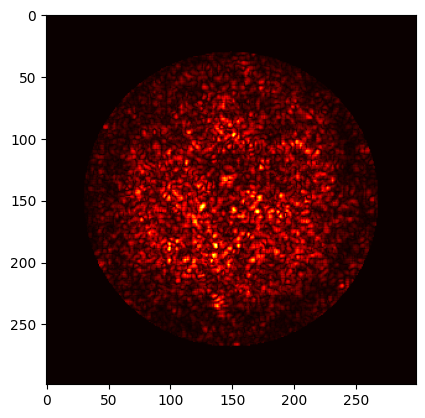

In [6]:
# Create a Circular Mask to focus on Brain
h, w = saliency_map.shape
circular_mask = create_circular_mask(h, w)
# remove areas outside the mask
saliency_map[~circular_mask] = 0
plt.imshow(saliency_map, cmap='hot')

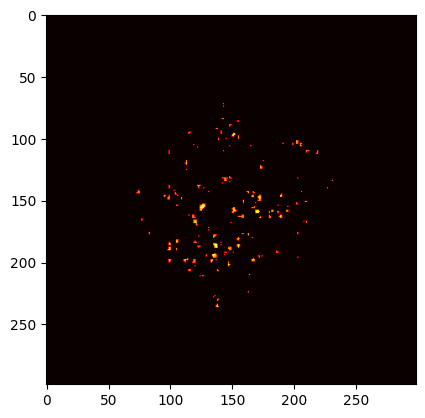

In [7]:
# Normalize
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Apply threshold to highlight strong activations
threshold = np.percentile(saliency_map[circular_mask], 99)
saliency_map[saliency_map < threshold] = 0

plt.imshow(saliency_map, cmap='hot')

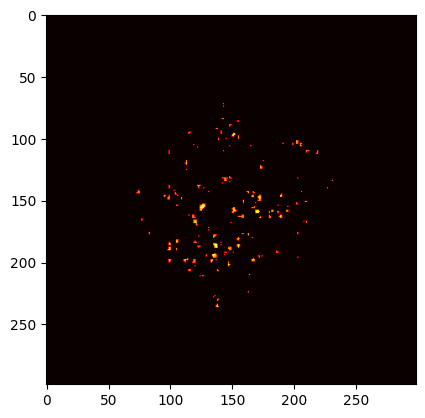

In [8]:
# Convert grayscale to heatmap using OpenCV
heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_HOT)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Apply Gausian Smoothening
heatmap = cv2.GaussianBlur(heatmap, (15, 15), 0)
plt.imshow(saliency_map, cmap='hot')

In [9]:
# Overlay on Original Image
original_image = image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
heatmap = (heatmap).astype(np.float32)

# Superimpose heatmap onto the original image
overlay = cv2.addWeighted(original_image, 0.8, heatmap, 0.1, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


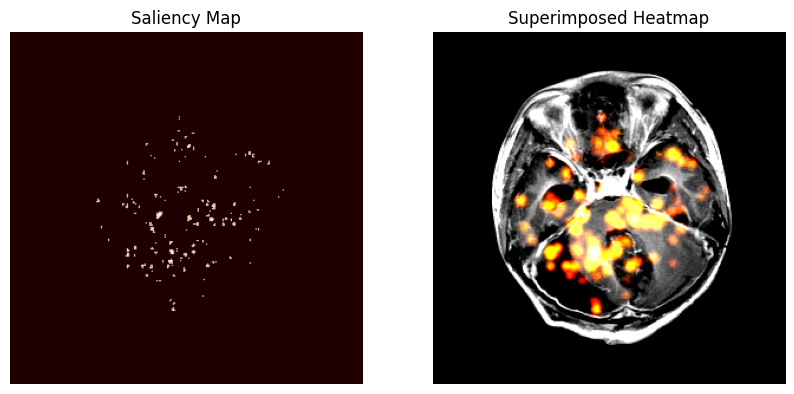

In [10]:
# Show final result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap="pink")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Superimposed Heatmap")
plt.imshow(overlay)
plt.axis("off")

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


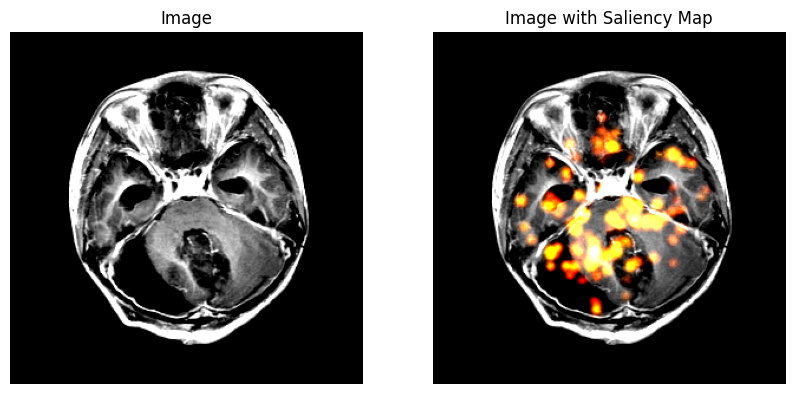

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(original_image, cmap="hot")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image with Saliency Map")
plt.imshow(overlay, cmap="hot")
plt.axis("off")

plt.show()